# Tests the detector SNR

This is to compare the detector SNR with and without the photon-counting mode. Might as well do this with the shaped pupil.

In [1]:
%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'nearest'
import sys
import os
import numpy as np
from astropy.io import fits

folder = '../../../../crispy'
print(folder)
if folder not in sys.path: sys.path.append(folder)

from crispy.params import Params
folder = '../../../crispy'

from crispy.tools.initLogger import getLogger
log = getLogger('crispy')
par = Params()


Populating the interactive namespace from numpy and matplotlib
../../../../crispy


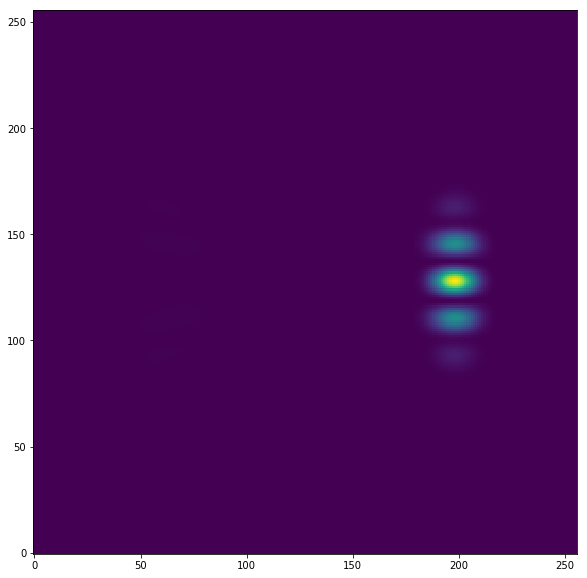

In [2]:
# load model
offaxispsf= '/Users/mrizzo/IFS/OS5/offaxis/spc_offaxis_psf.fits'

offaxis = fits.open(offaxispsf)[0].data
offaxis = np.sum(offaxis,axis=0)
plt.figure(figsize=(10,10))
plt.imshow(offaxis)


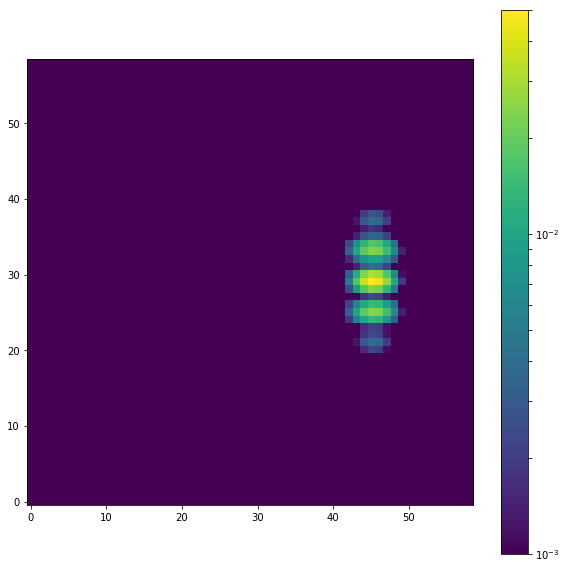

In [3]:
# rebin model to reflect real detector sampling
from crispy.tools.detutils import frebin
currentpix = 0.1 # at 770nm
newpix = 0.5*660./770.
newshape = (int(offaxis.shape[0]*currentpix/newpix),int(offaxis.shape[1]*currentpix/newpix))
offaxis_rebin = frebin(offaxis,newshape)
offaxis_rebin /= np.sum(offaxis_rebin)
from matplotlib.colors import LogNorm
plt.figure(figsize=(10,10))
plt.imshow(offaxis_rebin,norm=LogNorm(1e-3,0.05))
plt.colorbar()

Keeping 93.36% of the flux


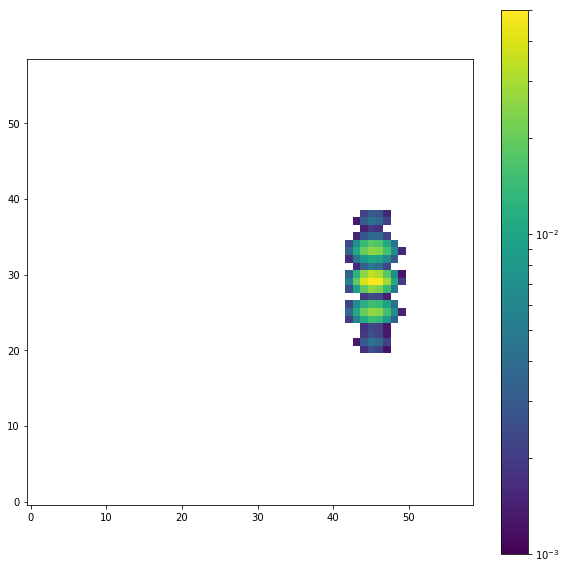

In [4]:
offaxis_rebin[offaxis_rebin<1e-3]=0
new_sum = np.sum(offaxis_rebin)
print("Keeping %2.2f%% of the flux" % (new_sum*100.))
offaxis_rebin /= new_sum
plt.figure(figsize=(10,10))
plt.imshow(offaxis_rebin,norm=LogNorm(1e-3,0.05))
plt.colorbar()

### Construct a matched filter to extract the flux

Irrespectively of the PSF normalization, let's try to extract the flux within the brightest pixels

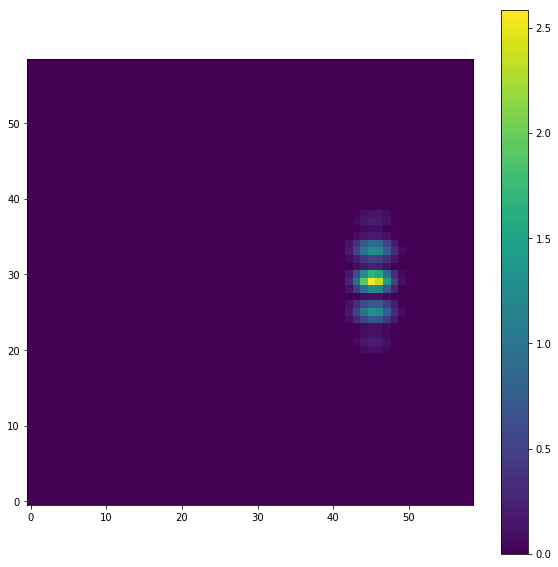

In [5]:
matched_filter = offaxis_rebin/np.sum(offaxis_rebin**2)
plt.figure(figsize=(10,10))
plt.imshow(matched_filter)
plt.colorbar()

In [6]:
# show that we can retrieve the original unity flux from the offaxis_rebin PSF
print np.sum(matched_filter*offaxis_rebin)

1.0


### Applying detector noise

('Total number of photons per second in PSF:', 0.063888888888888912)
('Total number of photons per frame in noiseless case:', 2.1722222222222234)


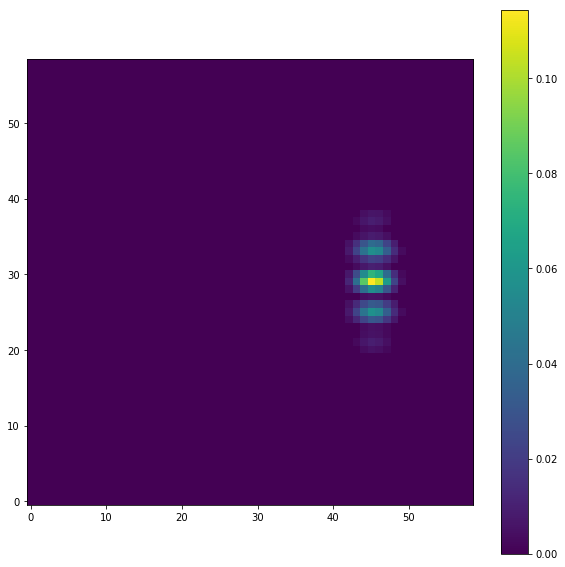

In [7]:
from crispy.tools.detector import readDetector
from crispy.tools.image import Image

# Approximate number of photons per IFS cube slice per frame
Nphot = 3.45/18 # 18 slices
Npix = 3 # suppose that the photons are spread over 3 pixels at IFS detector for each slice


img = Image(data=offaxis_rebin*Nphot/Npix)
print('Total number of photons per second in PSF:', np.sum(matched_filter*img.data))

det_nonoise = readDetector(par,img,inttime=100,nonoise=True)

print('Total number of photons per frame in noiseless case:', np.sum(matched_filter*det_nonoise))

plt.figure(figsize=(10,10))
plt.imshow(det_nonoise)
plt.colorbar()

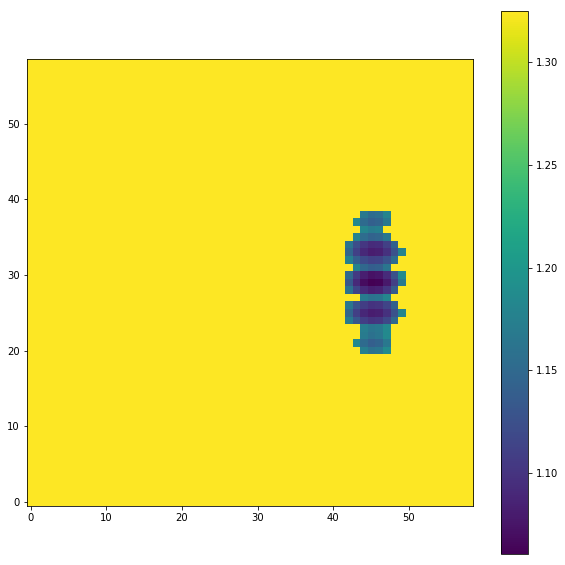

In [21]:
eff=par.losses*par.PhCountEff*par.pol
average = img.data*eff*100
average[average==0.0] = 1e-4
ave_before = average.copy()
beforeEMRegister = average# np.random.poisson(average)
average[beforeEMRegister>0] *= np.minimum(np.ones(beforeEMRegister[beforeEMRegister>0].shape),1+par.lifefraction*0.51296*(np.log10(beforeEMRegister[beforeEMRegister>0])+0.0147233))
#CTE = np.minimum(np.ones(beforeEMRegister.shape),1+par.lifefraction*0.51296*(np.log10(beforeEMRegister)+0.0147233))
plt.figure(figsize=(10,10))
plt.imshow(ave_before/average)

plt.colorbar()


TypeError: Invalid dimensions for image data

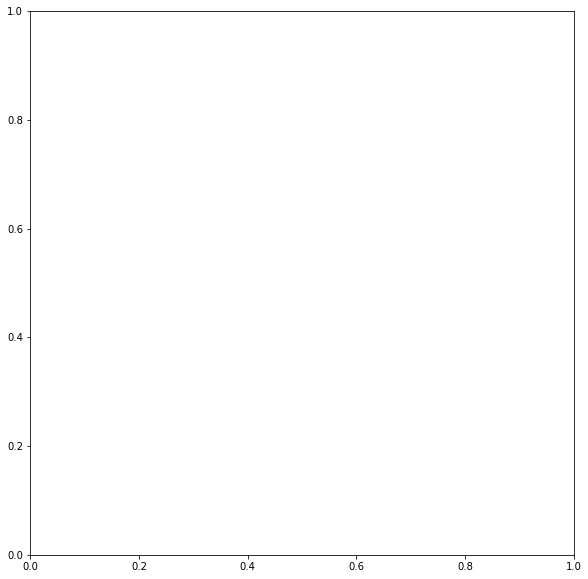

In [9]:

det = readDetector(par,img,inttime=100)
N = 999
for i in range(N):
    det += readDetector(par,img,inttime=100)

plt.figure(figsize=(10,10))
plt.imshow(det/(N+1))
plt.colorbar()
print("Signal: ", np.sum(matched_filter*(det/(N+1))))
print("Noise: ", np.sum(matched_filter)*np.std(det[:,:30]/(N+1)))
print("SNR: ",np.sum(matched_filter*(det/(N+1)))/(np.sum(matched_filter)*np.std(det[:,:30]/(N+1))))

In [ ]:
par.PCmode=False
det = readDetector(par,img,inttime=100)
N = 999
for i in range(N):
    det += readDetector(par,img,inttime=100)

plt.figure(figsize=(10,10))
plt.imshow(det/(N+1))
plt.colorbar()
print("Signal: ", np.sum(matched_filter*(det/(N+1))))
print("Noise: ", np.sum(matched_filter)*np.std(det[:,:30]/(N+1)))
print("SNR: ",np.sum(matched_filter*(det/(N+1)))/(np.sum(matched_filter)*np.std(det[:,:30]/(N+1))))

In [ ]:
det_offaxis = Image("/Users/mrizzo//IFS/crispy/crispy/OS5/OS5_average/offaxis.fits")
par.PCmode=False
det = readDetector(par,det_offaxis,inttime=3600,nonoise=True)
plt.figure(figsize=(10,10))
plt.imshow(det)
plt.colorbar()


# Least-squares slice-by-slice scaling between 2 cubes

In [ ]:
from crispy.tools.imgtools import bowtie
refcube = Image("/Users/mrizzo/IFS/crispy/crispy/SimResults/average_ref_star_detector_red_optext.fits")
targetcube = Image("/Users/mrizzo/IFS/crispy/crispy/SimResults/average_target_star_detector_red_optext.fits")
ydim,xdim = refcube.data[0].shape
mask,junk = bowtie(refcube.data[0],ydim//2,xdim//2,openingAngle=65,
            clocking=-par.philens*180./np.pi,IWApix=6*0.77/0.6,OWApix=18*0.77/0.6,
            export=None,twomasks=False)

refcube.data[np.isnan(refcube.data)]=0.0
targetcube.data[np.isnan(targetcube.data)]=0.0
res = []
vals = np.arange(1,20)
for i in range(refcube.data.shape[0]):
    refcube.data[i] *= mask
    targetcube.data[i] *= mask
#     targetcube.data[i] = refcube.data[i].copy()*0.5
    refslice = np.reshape(refcube.data[i], (1, -1))
    targetslice = np.reshape(refcube.data[i]*vals[i],-1)
    res.append(np.linalg.lstsq(refslice.T,targetslice)[0])
res=np.array(res).flatten()
print res.shape
plt.figure(figsize=(10,10))
print refcube.data.shape
resid = refcube.data*res[:,np.newaxis,np.newaxis]-refcube.data*vals[:,np.newaxis,np.newaxis]
plt.imshow(resid[0])
plt.colorbar()
print res


# Function that offsets an entire cube

In [ ]:
origcube = Image("/Users/mrizzo//IFS/crispy/crispy/OS5/OS5_average/offaxis.fits")
dx = 2
dy = 2
